In [21]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plot
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
batch_size = 32
X_dim = 784
z_dim = 10
h_dim = 128

In [4]:
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
def plot_images(samples):
    fig = plot.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plot.subplot(gs[i])
        plot.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plot.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [6]:
def xavier_init(size):
    input_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(input_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [7]:
X = tf.placeholder(tf.float32, shape=[None, X_dim])

D_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]


z = tf.placeholder(tf.float32, shape=[None, z_dim])

G_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

In [9]:
def get_sample_z(size):
    return np.random.uniform(-1., 1., size=size)

In [10]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_out = tf.nn.sigmoid(tf.matmul(G_h1, G_W2) + G_b2)
    return G_out

In [11]:
def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_out = tf.matmul(D_h1, D_W2) + D_b2
    return D_out

In [13]:
generator_sample = generator(z)
discriminator_real = discriminator(X)
discriminator_fake = discriminator(generator_sample)

In [15]:
d_loss = tf.reduce_mean(discriminator_fake) - tf.reduce_mean(discriminator_real)
g_loss = -tf.reduce_mean(discriminator_fake)

In [16]:
d_step = (tf.train.RMSPropOptimizer(learning_rate=1e-4).minimize(d_loss, var_list=theta_D))
g_step = (tf.train.RMSPropOptimizer(learning_rate=1e-4).minimize(g_loss, var_list=theta_G))

clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in theta_D]

In [17]:
sess = tf.InteractiveSession()

In [18]:
sess.run(tf.global_variables_initializer())

Iteration: 0 - Discriminator Loss: 0.2739, Generator Loss: 0.4356


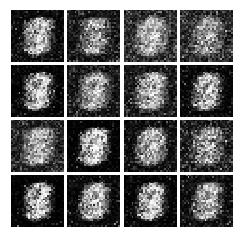

Iteration: 100 - Discriminator Loss: 0.2044, Generator Loss: 0.3499
Iteration: 200 - Discriminator Loss: 0.1216, Generator Loss: 0.1381
Iteration: 300 - Discriminator Loss: 0.03389, Generator Loss: 0.07269
Iteration: 400 - Discriminator Loss: 0.03772, Generator Loss: 0.03976
Iteration: 500 - Discriminator Loss: 0.03008, Generator Loss: 0.002651
Iteration: 600 - Discriminator Loss: 0.01278, Generator Loss: 0.03758
Iteration: 700 - Discriminator Loss: 0.01759, Generator Loss: -0.06396
Iteration: 800 - Discriminator Loss: 0.005727, Generator Loss: -0.02426
Iteration: 900 - Discriminator Loss: -0.008682, Generator Loss: -0.06818
Iteration: 1000 - Discriminator Loss: 0.007219, Generator Loss: 0.02284


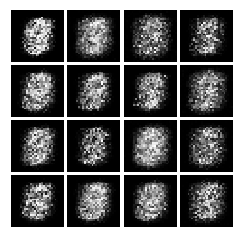

Iteration: 1100 - Discriminator Loss: -0.009305, Generator Loss: 0.01385
Iteration: 1200 - Discriminator Loss: 0.005757, Generator Loss: 0.01146
Iteration: 1300 - Discriminator Loss: 0.005897, Generator Loss: 0.004056
Iteration: 1400 - Discriminator Loss: 0.0004363, Generator Loss: 0.01131
Iteration: 1500 - Discriminator Loss: 0.003254, Generator Loss: -0.03449
Iteration: 1600 - Discriminator Loss: 0.0001154, Generator Loss: 0.03261
Iteration: 1700 - Discriminator Loss: 0.003064, Generator Loss: 0.05167
Iteration: 1800 - Discriminator Loss: 0.006483, Generator Loss: -0.04564
Iteration: 1900 - Discriminator Loss: 0.006423, Generator Loss: 0.01558
Iteration: 2000 - Discriminator Loss: -0.00173, Generator Loss: 0.06976


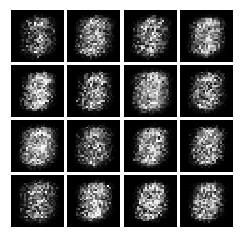

Iteration: 2100 - Discriminator Loss: 0.0004089, Generator Loss: -0.004959
Iteration: 2200 - Discriminator Loss: 0.002783, Generator Loss: -0.03438
Iteration: 2300 - Discriminator Loss: -0.005151, Generator Loss: -0.05003
Iteration: 2400 - Discriminator Loss: 0.003981, Generator Loss: 0.008593
Iteration: 2500 - Discriminator Loss: 0.002234, Generator Loss: -0.03686
Iteration: 2600 - Discriminator Loss: 0.008022, Generator Loss: -0.01392
Iteration: 2700 - Discriminator Loss: 0.0344, Generator Loss: -0.004226
Iteration: 2800 - Discriminator Loss: 0.04303, Generator Loss: -0.02461
Iteration: 2900 - Discriminator Loss: 0.04355, Generator Loss: -0.06311
Iteration: 3000 - Discriminator Loss: 0.04105, Generator Loss: 0.03544


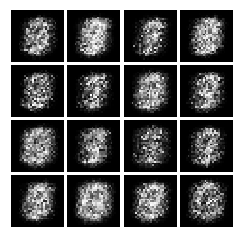

Iteration: 3100 - Discriminator Loss: 0.03235, Generator Loss: -0.01526
Iteration: 3200 - Discriminator Loss: 0.03589, Generator Loss: -0.001622
Iteration: 3300 - Discriminator Loss: 0.04061, Generator Loss: -0.01009
Iteration: 3400 - Discriminator Loss: 0.04534, Generator Loss: -0.03551
Iteration: 3500 - Discriminator Loss: 0.02412, Generator Loss: 0.01011
Iteration: 3600 - Discriminator Loss: 0.05069, Generator Loss: -0.01911
Iteration: 3700 - Discriminator Loss: 0.04393, Generator Loss: -0.004081
Iteration: 3800 - Discriminator Loss: 0.03988, Generator Loss: -0.02105
Iteration: 3900 - Discriminator Loss: 0.05161, Generator Loss: 0.01998
Iteration: 4000 - Discriminator Loss: 0.05389, Generator Loss: -0.004497


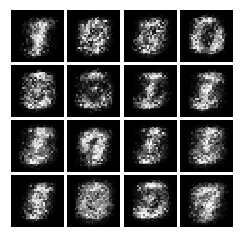

Iteration: 4100 - Discriminator Loss: 0.06034, Generator Loss: -0.02477
Iteration: 4200 - Discriminator Loss: 0.04779, Generator Loss: 0.01042
Iteration: 4300 - Discriminator Loss: 0.05803, Generator Loss: 0.01631
Iteration: 4400 - Discriminator Loss: 0.04751, Generator Loss: -0.02365
Iteration: 4500 - Discriminator Loss: 0.04993, Generator Loss: -0.01549
Iteration: 4600 - Discriminator Loss: 0.04976, Generator Loss: -0.02581
Iteration: 4700 - Discriminator Loss: 0.04734, Generator Loss: -0.007777
Iteration: 4800 - Discriminator Loss: 0.04275, Generator Loss: -0.01749
Iteration: 4900 - Discriminator Loss: 0.0489, Generator Loss: 0.003129
Iteration: 5000 - Discriminator Loss: 0.04329, Generator Loss: 0.006993


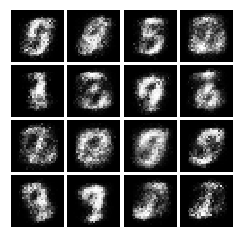

Iteration: 5100 - Discriminator Loss: 0.04146, Generator Loss: 0.0137
Iteration: 5200 - Discriminator Loss: 0.04212, Generator Loss: -0.01994
Iteration: 5300 - Discriminator Loss: 0.04415, Generator Loss: 0.013
Iteration: 5400 - Discriminator Loss: 0.04282, Generator Loss: 0.01064
Iteration: 5500 - Discriminator Loss: 0.04186, Generator Loss: -0.01848
Iteration: 5600 - Discriminator Loss: 0.0412, Generator Loss: -0.04129
Iteration: 5700 - Discriminator Loss: 0.03842, Generator Loss: -0.03989
Iteration: 5800 - Discriminator Loss: 0.04798, Generator Loss: -0.01024
Iteration: 5900 - Discriminator Loss: 0.04976, Generator Loss: -0.0223
Iteration: 6000 - Discriminator Loss: 0.04843, Generator Loss: -0.02167


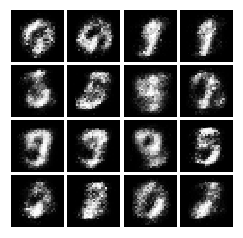

Iteration: 6100 - Discriminator Loss: 0.0508, Generator Loss: -0.01725
Iteration: 6200 - Discriminator Loss: 0.04329, Generator Loss: -0.01598
Iteration: 6300 - Discriminator Loss: 0.05231, Generator Loss: -0.01729
Iteration: 6400 - Discriminator Loss: 0.05316, Generator Loss: -0.01876
Iteration: 6500 - Discriminator Loss: 0.04873, Generator Loss: -0.01372
Iteration: 6600 - Discriminator Loss: 0.05216, Generator Loss: -0.01428
Iteration: 6700 - Discriminator Loss: 0.0483, Generator Loss: -0.01638
Iteration: 6800 - Discriminator Loss: 0.05107, Generator Loss: -0.01772
Iteration: 6900 - Discriminator Loss: 0.05695, Generator Loss: -0.0191
Iteration: 7000 - Discriminator Loss: 0.04979, Generator Loss: -0.02157


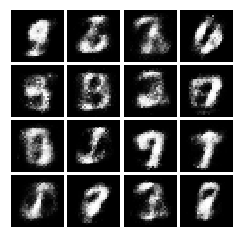

Iteration: 7100 - Discriminator Loss: 0.0428, Generator Loss: -0.01859
Iteration: 7200 - Discriminator Loss: 0.04979, Generator Loss: -0.01574
Iteration: 7300 - Discriminator Loss: 0.05193, Generator Loss: -0.01977
Iteration: 7400 - Discriminator Loss: 0.04886, Generator Loss: -0.01447
Iteration: 7500 - Discriminator Loss: 0.04578, Generator Loss: -0.01767
Iteration: 7600 - Discriminator Loss: 0.04964, Generator Loss: -0.01998
Iteration: 7700 - Discriminator Loss: 0.05262, Generator Loss: -0.02112
Iteration: 7800 - Discriminator Loss: 0.05238, Generator Loss: -0.02098
Iteration: 7900 - Discriminator Loss: 0.0478, Generator Loss: -0.02136
Iteration: 8000 - Discriminator Loss: 0.05126, Generator Loss: -0.02177


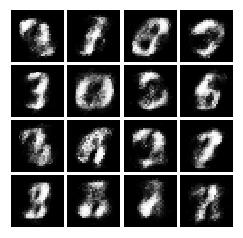

Iteration: 8100 - Discriminator Loss: 0.04463, Generator Loss: -0.02347
Iteration: 8200 - Discriminator Loss: 0.04753, Generator Loss: -0.01858
Iteration: 8300 - Discriminator Loss: 0.04195, Generator Loss: -0.0238
Iteration: 8400 - Discriminator Loss: 0.04252, Generator Loss: -0.02539
Iteration: 8500 - Discriminator Loss: 0.03717, Generator Loss: -0.02809
Iteration: 8600 - Discriminator Loss: 0.03825, Generator Loss: -0.02435
Iteration: 8700 - Discriminator Loss: 0.04754, Generator Loss: -0.02829
Iteration: 8800 - Discriminator Loss: 0.04545, Generator Loss: -0.02278
Iteration: 8900 - Discriminator Loss: 0.03748, Generator Loss: -0.02383
Iteration: 9000 - Discriminator Loss: 0.04646, Generator Loss: -0.02358


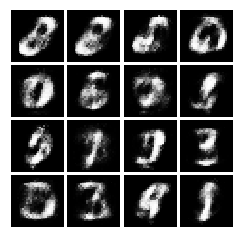

Iteration: 9100 - Discriminator Loss: 0.04701, Generator Loss: -0.02229
Iteration: 9200 - Discriminator Loss: 0.03961, Generator Loss: -0.02182
Iteration: 9300 - Discriminator Loss: 0.03692, Generator Loss: -0.0232
Iteration: 9400 - Discriminator Loss: 0.03673, Generator Loss: -0.02128
Iteration: 9500 - Discriminator Loss: 0.03681, Generator Loss: -0.02069
Iteration: 9600 - Discriminator Loss: 0.03289, Generator Loss: -0.01875
Iteration: 9700 - Discriminator Loss: 0.03521, Generator Loss: -0.02032
Iteration: 9800 - Discriminator Loss: 0.03716, Generator Loss: -0.02014
Iteration: 9900 - Discriminator Loss: 0.0387, Generator Loss: -0.02387
Iteration: 10000 - Discriminator Loss: 0.0398, Generator Loss: -0.02138


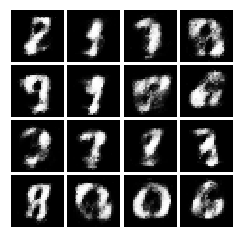

Iteration: 10100 - Discriminator Loss: 0.03572, Generator Loss: -0.02187
Iteration: 10200 - Discriminator Loss: 0.0387, Generator Loss: -0.01938
Iteration: 10300 - Discriminator Loss: 0.03879, Generator Loss: -0.02573
Iteration: 10400 - Discriminator Loss: 0.04153, Generator Loss: -0.02345
Iteration: 10500 - Discriminator Loss: 0.03172, Generator Loss: -0.02133
Iteration: 10600 - Discriminator Loss: 0.03867, Generator Loss: -0.02395
Iteration: 10700 - Discriminator Loss: 0.03272, Generator Loss: -0.02113
Iteration: 10800 - Discriminator Loss: 0.04028, Generator Loss: -0.02451
Iteration: 10900 - Discriminator Loss: 0.03727, Generator Loss: -0.02533
Iteration: 11000 - Discriminator Loss: 0.03597, Generator Loss: -0.02358


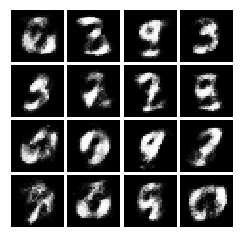

Iteration: 11100 - Discriminator Loss: 0.03742, Generator Loss: -0.02335
Iteration: 11200 - Discriminator Loss: 0.03767, Generator Loss: -0.02071
Iteration: 11300 - Discriminator Loss: 0.03234, Generator Loss: -0.02189
Iteration: 11400 - Discriminator Loss: 0.02994, Generator Loss: -0.02014
Iteration: 11500 - Discriminator Loss: 0.03198, Generator Loss: -0.0255
Iteration: 11600 - Discriminator Loss: 0.03684, Generator Loss: -0.02246
Iteration: 11700 - Discriminator Loss: 0.0402, Generator Loss: -0.02157
Iteration: 11800 - Discriminator Loss: 0.03075, Generator Loss: -0.02428
Iteration: 11900 - Discriminator Loss: 0.03528, Generator Loss: -0.02116
Iteration: 12000 - Discriminator Loss: 0.03036, Generator Loss: -0.02181


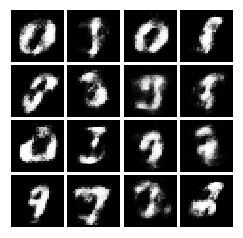

Iteration: 12100 - Discriminator Loss: 0.03798, Generator Loss: -0.02077
Iteration: 12200 - Discriminator Loss: 0.03587, Generator Loss: -0.02452
Iteration: 12300 - Discriminator Loss: 0.03595, Generator Loss: -0.02174
Iteration: 12400 - Discriminator Loss: 0.03455, Generator Loss: -0.02075
Iteration: 12500 - Discriminator Loss: 0.03591, Generator Loss: -0.02056
Iteration: 12600 - Discriminator Loss: 0.03329, Generator Loss: -0.02388
Iteration: 12700 - Discriminator Loss: 0.02649, Generator Loss: -0.02003
Iteration: 12800 - Discriminator Loss: 0.0286, Generator Loss: -0.02041
Iteration: 12900 - Discriminator Loss: 0.02736, Generator Loss: -0.02084
Iteration: 13000 - Discriminator Loss: 0.03435, Generator Loss: -0.02499


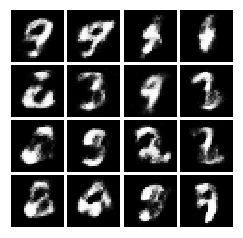

Iteration: 13100 - Discriminator Loss: 0.03136, Generator Loss: -0.02035
Iteration: 13200 - Discriminator Loss: 0.03716, Generator Loss: -0.02145
Iteration: 13300 - Discriminator Loss: 0.03168, Generator Loss: -0.02246
Iteration: 13400 - Discriminator Loss: 0.03177, Generator Loss: -0.02262
Iteration: 13500 - Discriminator Loss: 0.02774, Generator Loss: -0.0224
Iteration: 13600 - Discriminator Loss: 0.03104, Generator Loss: -0.02001
Iteration: 13700 - Discriminator Loss: 0.03482, Generator Loss: -0.02429
Iteration: 13800 - Discriminator Loss: 0.02784, Generator Loss: -0.02062
Iteration: 13900 - Discriminator Loss: 0.03674, Generator Loss: -0.02233
Iteration: 14000 - Discriminator Loss: 0.02891, Generator Loss: -0.02153


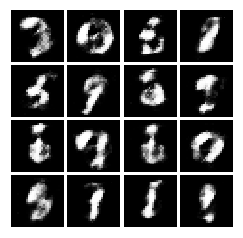

Iteration: 14100 - Discriminator Loss: 0.03233, Generator Loss: -0.02251
Iteration: 14200 - Discriminator Loss: 0.02931, Generator Loss: -0.02254
Iteration: 14300 - Discriminator Loss: 0.03097, Generator Loss: -0.02449
Iteration: 14400 - Discriminator Loss: 0.03259, Generator Loss: -0.02137
Iteration: 14500 - Discriminator Loss: 0.0316, Generator Loss: -0.02108
Iteration: 14600 - Discriminator Loss: 0.02612, Generator Loss: -0.02334
Iteration: 14700 - Discriminator Loss: 0.02681, Generator Loss: -0.02115
Iteration: 14800 - Discriminator Loss: 0.02995, Generator Loss: -0.02062
Iteration: 14900 - Discriminator Loss: 0.02644, Generator Loss: -0.02141
Iteration: 15000 - Discriminator Loss: 0.02753, Generator Loss: -0.02404


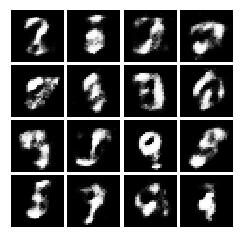

Iteration: 15100 - Discriminator Loss: 0.03156, Generator Loss: -0.01991
Iteration: 15200 - Discriminator Loss: 0.02415, Generator Loss: -0.02168
Iteration: 15300 - Discriminator Loss: 0.02951, Generator Loss: -0.02319
Iteration: 15400 - Discriminator Loss: 0.02967, Generator Loss: -0.02447
Iteration: 15500 - Discriminator Loss: 0.02852, Generator Loss: -0.02336
Iteration: 15600 - Discriminator Loss: 0.02876, Generator Loss: -0.02089
Iteration: 15700 - Discriminator Loss: 0.0272, Generator Loss: -0.02215
Iteration: 15800 - Discriminator Loss: 0.02751, Generator Loss: -0.0217
Iteration: 15900 - Discriminator Loss: 0.0324, Generator Loss: -0.02103
Iteration: 16000 - Discriminator Loss: 0.02965, Generator Loss: -0.02409


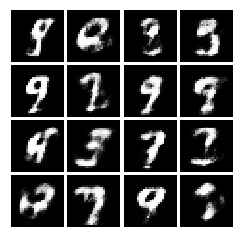

Iteration: 16100 - Discriminator Loss: 0.02915, Generator Loss: -0.02341
Iteration: 16200 - Discriminator Loss: 0.02455, Generator Loss: -0.02208
Iteration: 16300 - Discriminator Loss: 0.02387, Generator Loss: -0.02264
Iteration: 16400 - Discriminator Loss: 0.02619, Generator Loss: -0.02632
Iteration: 16500 - Discriminator Loss: 0.02716, Generator Loss: -0.02181
Iteration: 16600 - Discriminator Loss: 0.02779, Generator Loss: -0.02656
Iteration: 16700 - Discriminator Loss: 0.02646, Generator Loss: -0.02079
Iteration: 16800 - Discriminator Loss: 0.02445, Generator Loss: -0.02144
Iteration: 16900 - Discriminator Loss: 0.02649, Generator Loss: -0.02333
Iteration: 17000 - Discriminator Loss: 0.02462, Generator Loss: -0.02064


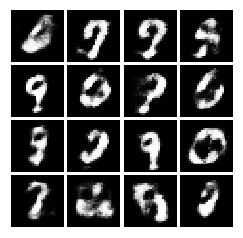

Iteration: 17100 - Discriminator Loss: 0.02421, Generator Loss: -0.02123
Iteration: 17200 - Discriminator Loss: 0.02643, Generator Loss: -0.02431
Iteration: 17300 - Discriminator Loss: 0.02427, Generator Loss: -0.02323
Iteration: 17400 - Discriminator Loss: 0.03106, Generator Loss: -0.02329
Iteration: 17500 - Discriminator Loss: 0.02018, Generator Loss: -0.02481
Iteration: 17600 - Discriminator Loss: 0.02617, Generator Loss: -0.02276
Iteration: 17700 - Discriminator Loss: 0.02627, Generator Loss: -0.0221
Iteration: 17800 - Discriminator Loss: 0.02558, Generator Loss: -0.02468
Iteration: 17900 - Discriminator Loss: 0.02769, Generator Loss: -0.02885
Iteration: 18000 - Discriminator Loss: 0.02317, Generator Loss: -0.02384


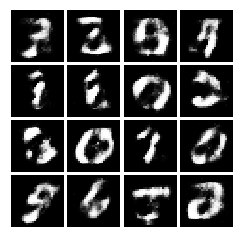

Iteration: 18100 - Discriminator Loss: 0.02274, Generator Loss: -0.02495
Iteration: 18200 - Discriminator Loss: 0.03008, Generator Loss: -0.02497
Iteration: 18300 - Discriminator Loss: 0.02578, Generator Loss: -0.02096
Iteration: 18400 - Discriminator Loss: 0.02644, Generator Loss: -0.0246
Iteration: 18500 - Discriminator Loss: 0.02853, Generator Loss: -0.02141
Iteration: 18600 - Discriminator Loss: 0.02769, Generator Loss: -0.02982
Iteration: 18700 - Discriminator Loss: 0.02688, Generator Loss: -0.02394
Iteration: 18800 - Discriminator Loss: 0.02739, Generator Loss: -0.02402
Iteration: 18900 - Discriminator Loss: 0.02347, Generator Loss: -0.02588
Iteration: 19000 - Discriminator Loss: 0.02015, Generator Loss: -0.02552


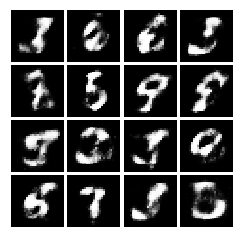

Iteration: 19100 - Discriminator Loss: 0.02869, Generator Loss: -0.02451
Iteration: 19200 - Discriminator Loss: 0.02493, Generator Loss: -0.02276
Iteration: 19300 - Discriminator Loss: 0.02269, Generator Loss: -0.02334
Iteration: 19400 - Discriminator Loss: 0.02359, Generator Loss: -0.02674
Iteration: 19500 - Discriminator Loss: 0.02189, Generator Loss: -0.02483
Iteration: 19600 - Discriminator Loss: 0.02473, Generator Loss: -0.02596
Iteration: 19700 - Discriminator Loss: 0.02093, Generator Loss: -0.02127
Iteration: 19800 - Discriminator Loss: 0.0232, Generator Loss: -0.02857
Iteration: 19900 - Discriminator Loss: 0.02329, Generator Loss: -0.02373
Iteration: 20000 - Discriminator Loss: 0.0235, Generator Loss: -0.02649


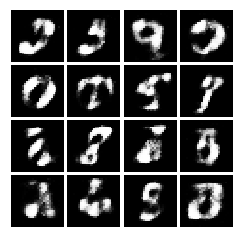

Iteration: 20100 - Discriminator Loss: 0.02291, Generator Loss: -0.02444
Iteration: 20200 - Discriminator Loss: 0.02326, Generator Loss: -0.02549
Iteration: 20300 - Discriminator Loss: 0.01929, Generator Loss: -0.01969
Iteration: 20400 - Discriminator Loss: 0.02114, Generator Loss: -0.02476
Iteration: 20500 - Discriminator Loss: 0.02091, Generator Loss: -0.0275
Iteration: 20600 - Discriminator Loss: 0.02337, Generator Loss: -0.02144
Iteration: 20700 - Discriminator Loss: 0.02113, Generator Loss: -0.02327
Iteration: 20800 - Discriminator Loss: 0.01986, Generator Loss: -0.02372
Iteration: 20900 - Discriminator Loss: 0.02148, Generator Loss: -0.02387
Iteration: 21000 - Discriminator Loss: 0.02545, Generator Loss: -0.02498


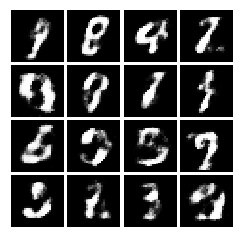

Iteration: 21100 - Discriminator Loss: 0.02602, Generator Loss: -0.02395
Iteration: 21200 - Discriminator Loss: 0.02174, Generator Loss: -0.02327
Iteration: 21300 - Discriminator Loss: 0.01819, Generator Loss: -0.02179
Iteration: 21400 - Discriminator Loss: 0.02468, Generator Loss: -0.02083
Iteration: 21500 - Discriminator Loss: 0.02313, Generator Loss: -0.0259
Iteration: 21600 - Discriminator Loss: 0.01729, Generator Loss: -0.02219
Iteration: 21700 - Discriminator Loss: 0.02356, Generator Loss: -0.02718


In [ ]:
for i in range(100000):
    for _ in range(5):
        x_batch, _ = mnist.train.next_batch(batch_size)

        _, d_loss_val, _ = sess.run(
            [d_step, d_loss, clip_D],
            feed_dict={X: x_batch, z: get_sample_z(size=(batch_size, z_dim))}
        )

    _, g_loss_val = sess.run(
        [g_step, g_loss],
        feed_dict={z: get_sample_z(size=(batch_size, z_dim))}
    )

    if i % 100 == 0:
        print('Iteration: {} - Discriminator Loss: {:.4}, Generator Loss: {:.4}'
              .format(i, -d_loss_val, g_loss_val))

        if i % 1000 == 0:
            samples = sess.run(generator_sample, feed_dict={z: get_sample_z(size=(16, z_dim))})

            fig = plot_images(samples)
            plot.show()
            i += 1
            plot.close(fig)